Вступ до комп’ютерного зору
Лабораторна робота No4
КПI iм. Iгоря Сiкорського
Листопад 2023

1 Видалення шуму
1.1 Мета
Метою цiєї лабораторної роботи є отримання навичок роботи з методами
видалення шуму з зображень.
1.2 Завдання
Виконати наступнi кроки:
1. Обрати декiлька (3+) зображень, без вираженого шуму.
2. Для кожного зображення додати наступнi типи шуму:
• Salt-Pepper (Iмпульсний шум)
• Gaussian noise (Нормальний шум)
3. Для кожного зображення застосувати наступнi методи видалення шу-
му:
• Box average (згладжування коробкою :D)
• Медiана
• Зважена медiана
4. Порiвняти результати, та зробити висновки.
5. (Опцiонально, +5 балiв) Виконати фiльтрацiю у HSV представленi, та
порiвняти результат з фiльтрацiєю в RGB.
1.3 Вимоги до виконання

• Дозволяється використання стороннiх модулiв лише для генерацiї шу-
му (Також додам .py файл готовими методами генерацiї шуму).

• Використовуйте вiртуальнi середовища (venv).
• Необхiднi для вашого коду модулi зберiгайте у файл “requirements.txt”,
та додавайте його на github разом с кодом.
• Код, оригiнальнi фото та отриманi результати залити на свiй github

• У classroom додати тiльки код та результати (для звiтностi), та поси-
лання на github.


In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import os

from numba import njit
from numba_progress import ProgressBar

In [2]:
# @njit(nogil=True)
def sp_noise_gray(image, prob=0.03):
    '''
    Add salt and pepper noise to a gray image [0,255]
    
    image: Numpy 2D array
    prob: Probability of the noise
    returns: Numpy 2D array
    '''    
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                image[i,j] = 0
            elif rdn > thres:
                image[i,j] = 255
    return image

# @njit(nogil=True)
def sp_noise_color(image, prob=0.03, white=[255,255,255], black=[0,0,0]):
    '''
    Add salt and pepper noise to a color image
    
    image: Numpy 2D array
    prob: Probability of the noise
    returns: Numpy 2D array
    '''    
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                image[i,j,:] = black
            elif rdn > thres:
                image[i,j,:] = white
    return image

In [3]:
# @njit(nogil=True)
def norm_noise_gray(image, mean=0, var=0.1, a=0.5):
    '''
    Add gaussian noise to gray image 
    
    image: Numpy 2D array
    mean: scalar
    vat: scalar
    returns: Numpy 2D array
    '''    
    sigma = var**0.5
    
    row,col= image.shape[:2]
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = a*image + (1-a)*gauss

    noisy = noisy-np.min(noisy)
    noisy = 255*(noisy/np.max(noisy))
    
    return noisy #.astype(np.uint8)

# @njit(nogil=True)
def norm_noise_color(image, mean=0, var=0.1, a=0.5):
    '''
    Add gaussian noise to color image 
    
    image: Numpy 2D array
    mean: scalar - mean
    var: scalar - variance
    a: scalar [0-1] - alpha blend
    returns: Numpy 2D array
    '''    
    sigma = var**0.5
    
    row,col,ch= image.shape[:3]
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = a*image + (1-a)*gauss

    noisy = noisy-np.min(noisy)
    noisy = 255*(noisy/np.max(noisy))
    
    return noisy #.astype(np.uint8)

In [4]:
@njit(nogil=True)
def box_average_color(image, filter_size=(9, 9)):
    '''
    Removes noise from color image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width, channels = image.shape
   
    height_fl, width_fl = filter_size
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for channel in range(channels):
        for row in range(height_limit, height - height_limit):
            row_start = row - height_limit
            row_finish = row + 2
            for col in range(width_limit, width - width_limit):
                res_image[row, col, channel] = np.mean(image[row_start:row_finish, col - width_limit:col + 2, channel])
    return res_image

@njit(nogil=True)
def box_average_gray(image, filter_size=(9, 9)):
    '''
    Removes noise from gray image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width = image.shape
   
    height_fl, width_fl = filter_size
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for row in range(height_limit, height - height_limit):
        row_start = row - height_limit
        row_finish = row + 2
        for col in range(width_limit, width - width_limit):
            res_image[row, col] = np.mean(image[row_start:row_finish, col - width_limit:col + 2])
    return res_image

In [5]:
@njit(nogil=True)
def median_color(image, filter_size=(9, 9)):
    '''
    Removes noise from color image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width, channels = image.shape
   
    height_fl, width_fl = filter_size
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for channel in range(channels):
        for row in range(height_limit, height - height_limit):
            row_start = row - height_limit
            row_finish = row + 2
            for col in range(width_limit, width - width_limit):
                res_image[row, col, channel] = np.median(image[row_start:row_finish, col - width_limit:col + 2, channel])
    return res_image

@njit(nogil=True)
def median_gray(image, filter_size=(9, 9)):
    '''
    Removes noise from gray image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    height, width = image.shape
   
    height_fl, width_fl = filter_size
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for row in range(height_limit, height - height_limit):
        row_start = row - height_limit
        row_finish = row + 2
        for col in range(width_limit, width - width_limit):
            res_image[row, col] = np.median(image[row_start:row_finish, col - width_limit:col + 2])
    return res_image

In [6]:
@njit(nogil=True)
def scale(filtered_ar1):
    maximum = np.max(filtered_ar1)
    minimum = np.min(filtered_ar1)
    filtered_ar1 = (255*(filtered_ar1 - minimum)/maximum).astype(np.uint8)#np.ptp(filtered_ar1)
    # print(maximum, minimum)
    return filtered_ar1

@njit(nogil=True)
def weight_median_color(image):
    '''
    Removes noise from color image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    # maximum = np.max(image)
    # minimum = np.min(image)
    # print(maximum, minimum)
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    m_filter = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])*1/16
    # print(m_filter)
    
    height, width, channels = image.shape
    
    height_fl, width_fl = m_filter.shape
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for channel in range(channels):
        for row in range(height_limit, height - height_limit):
            row_start = row - height_limit
            row_finish = row + 2
            for col in range(width_limit, width - width_limit):
                res_image[row, col, channel] = np.median(image[row_start:row_finish, col - width_limit:col + 2, channel]*m_filter)
    return scale(res_image)

@njit(nogil=True)
def weight_median_gray(image):
    '''
    Removes noise from gray image 
    
    image: Numpy 2D array
    returns: Numpy 2D array
    '''    
    image = image.astype(np.float32)
    res_image = np.zeros_like(image).astype(np.float32)
    m_filter = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])*1/16
    
    height, width = image.shape
    
    height_fl, width_fl = m_filter.shape
    
    height_limit = height_fl - 2
    width_limit = width_fl - 2
    
    for row in range(height_limit, height - height_limit):
        row_start = row - height_limit
        row_finish = row + 2
        for col in range(width_limit, width - width_limit):
            res_image[row, col] = np.median(image[row_start:row_finish, col - width_limit:col + 2]*m_filter)
    return scale(res_image)

In [12]:
print(sp_noise_img.shape)

(1920, 887, 3)


In [13]:
sp_noise_img

array([[[110,  74,  58],
        [108,  72,  56],
        [  0,   0,   0],
        ...,
        [ 48,  41,  31],
        [ 47,  40,  30],
        [ 45,  41,  30]],

       [[255, 255, 255],
        [109,  72,  56],
        [105,  68,  52],
        ...,
        [ 50,  40,  31],
        [ 48,  39,  30],
        [ 47,  40,  30]],

       [[110,  73,  57],
        [108,  71,  55],
        [105,  68,  52],
        ...,
        [ 53,  38,  31],
        [ 51,  38,  30],
        [ 51,  38,  30]],

       ...,

       [[255, 255, 255],
        [ 22,  12,  23],
        [  0,   0,   0],
        ...,
        [ 14,   0,  13],
        [  0,   0,   0],
        [ 14,   0,  13]],

       [[ 22,  12,  23],
        [ 22,  12,  23],
        [ 22,  12,  23],
        ...,
        [ 14,   0,  13],
        [ 14,   0,  13],
        [ 14,   0,  13]],

       [[ 22,  12,  23],
        [ 22,  12,  23],
        [ 22,  12,  23],
        ...,
        [ 14,   0,  13],
        [255, 255, 255],
        [ 14,   0,  13]]

In [40]:
import numpy as np

def rgb_to_hsv(rgb_image):
    # Normalize RGB values to the range [0, 1]
    normalized_rgb = rgb_image / 255.0

    # Extract individual channels
    R, G, B = normalized_rgb[:,:,0], normalized_rgb[:,:,1], normalized_rgb[:,:,2]

    # Calculate Hue
    hue = np.arctan2(np.sqrt(3) * (G - B), 2 * R - G - B)
    hue = np.degrees(hue) % 360  # Convert radians to degrees and keep in the range [0, 360]

    # Calculate Saturation
    saturation = np.sqrt((2 * (R - G) + (R - B))**2 + (G - B)**2)

    # Calculate Value
    value = (R + G + B) / 3

    # Scale the values to the range [0, 255]
    hue = (hue / 360) * 255
    saturation = (saturation / np.max(saturation)) * 255
    value = (value / np.max(value)) * 255

    # Stack the channels back together
    hsv_image = np.stack([hue, saturation, value], axis=-1)

    # Convert to integer type
    hsv_image = hsv_image.astype(np.uint8)

    return hsv_image

# Example usage
rgb_image = np.array([
    [[255, 0, 0], [0, 255, 0], [0, 0, 255]],
    [[255, 255, 0], [255, 0, 255], [0, 255, 255]],
], dtype=np.uint8)

hsv_image_manual = rgb_to_hsv(rgb_image)

print("RGB Image:")
print(rgb_image)
print("\nHSV Image (Manual):")
print(hsv_image_manual)


RGB Image:
[[[255   0   0]
  [  0 255   0]
  [  0   0 255]]

 [[255 255   0]
  [255   0 255]
  [  0 255 255]]]

HSV Image (Manual):
[[[  0 255 127]
  [ 85 190 127]
  [170 120 127]]

 [[ 42 120 255]
  [212 190 255]
  [127 255 255]]]


In [42]:
import numpy as np

def hsv_to_rgb(hsv_image):
    # Normalize HSV values to the range [0, 1]
    normalized_hsv = hsv_image / 255.0

    # Extract individual channels
    H, S, V = normalized_hsv[:,:,0], normalized_hsv[:,:,1], normalized_hsv[:,:,2]

    C = V * S
    X = C * (1 - np.abs((H / 60) % 2 - 1))
    m = V - C

    # Initialize RGB values to zero
    R, G, B = 0, 0, 0

    # Define conditions for each sector in the color wheel
    conditions = [
        (0 <= H) & (H < 60),
        (60 <= H) & (H < 120),
        (120 <= H) & (H < 180),
        (180 <= H) & (H < 240),
        (240 <= H) & (H < 300),
        (300 <= H) & (H < 360)
    ]

    # Calculate RGB values based on the conditions
    R = np.select(conditions, [C, X, 0, 0, X, C])
    G = np.select(conditions, [X, C, C, X, 0, 0])
    B = np.select(conditions, [0, 0, X, C, C, X])

    # Add m to each channel
    R = (R + m) * 255
    G = (G + m) * 255
    B = (B + m) * 255

    # Stack the channels back together
    rgb_image = np.stack([R, G, B], axis=-1)

    # Convert to integer type
    rgb_image = rgb_image.astype(np.uint8)

    return rgb_image

# Example usage
hsv_image = np.array([
    [[0, 255, 255], [120, 255, 255], [240, 255, 255]],
    [[60, 255, 255], [180, 255, 255], [300, 255, 255]],
], dtype=np.uint8)

rgb_image_manual = hsv_to_rgb(hsv_image)

print("HSV Image:")
print(hsv_image)
print("\nRGB Image (Manual):")
print(rgb_image_manual)


HSV Image:
[[[  0 255 255]
  [120 255 255]
  [240 255 255]]

 [[ 60 255 255]
  [180 255 255]
  [ 44 255 255]]]

RGB Image (Manual):
[[[255   0   0]
  [255   1   0]
  [255   3   0]]

 [[255   0   0]
  [255   2   0]
  [255   0   0]]]


C:\Users\dadmo\AppData\Local\Temp\ipykernel_18304\3111512859.py:46: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 300 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  hsv_image = np.array([


In [32]:
@njit(nogil=True)
def rgb2hsv(image_rgb):
    '''
    converts rgb to hsv
    
    image_rgb: Numpy 2D array 
    returns: Numpy 2D array
    '''
    image_hsv = np.zeros_like(image_rgb)
    
    height, width, channels = image_rgb.shape
    
    # for channel in range(channels):
    for row in range(height):
        for col in range(width):
            r, g, b = image_rgb[row,col,0], image_rgb[row,col,1], image_rgb[row,col,2]
            _r, _g, _b = r/255, g/255, b/255
            c_max = max(_r, _g, _b)
            c_min = min(_r, _g, _b)
            delta = c_max - c_min
            
            # hue 
            if delta == 0:
                h = np.degrees(0)
            elif c_max == _r:
                h = np.degrees(60) * (((_g - _b)/delta)%6)
            elif c_max == _g:
                h = np.degrees(60) * (((_b - _r)+2))
            elif c_max == _b:
                h = np.degrees(60) * (((_r - _g)+4))

                # saturation 
            if c_max == 0:
                s = 0
            elif c_max != 0:
                s = delta/c_max

            # value
            v = c_max
            
            image_hsv[row,col,0], image_hsv[row,col,1], image_hsv[row,col,2] = h, s, v
    return image_hsv

In [33]:
Image.fromarray(rgb2hsv(sp_noise_img)).save('results\\Horror.webp')

In [43]:
Image.fromarray(rgb_to_hsv(sp_noise_img)).save('results\\HorrorHSV.webp')

In [48]:
Image.fromarray(hsv_to_rgb(rgb_to_hsv(sp_noise_img))).save('results\\HorrorRGB.webp')

In [35]:
Image.fromarray(hsv_image_manual).save('results\\Horror.webp')

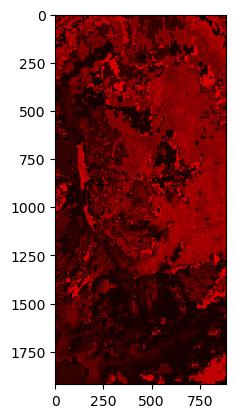

In [19]:
plt.imshow(rgb2hsv(sp_noise_img)

  0%|                                                                                           | 0/34 [00:00<…

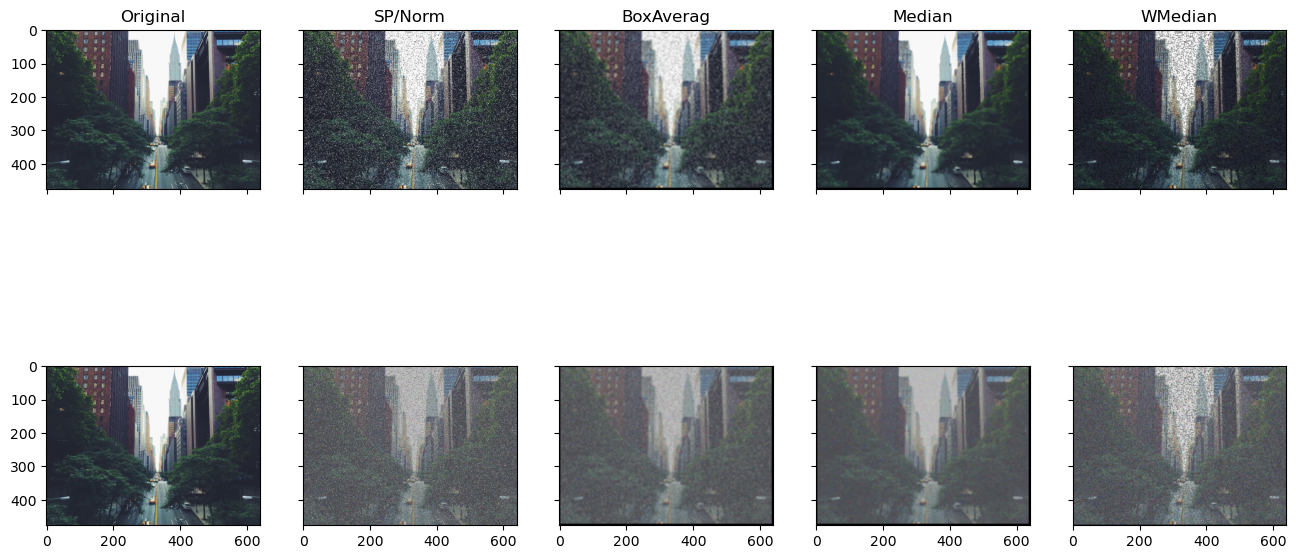

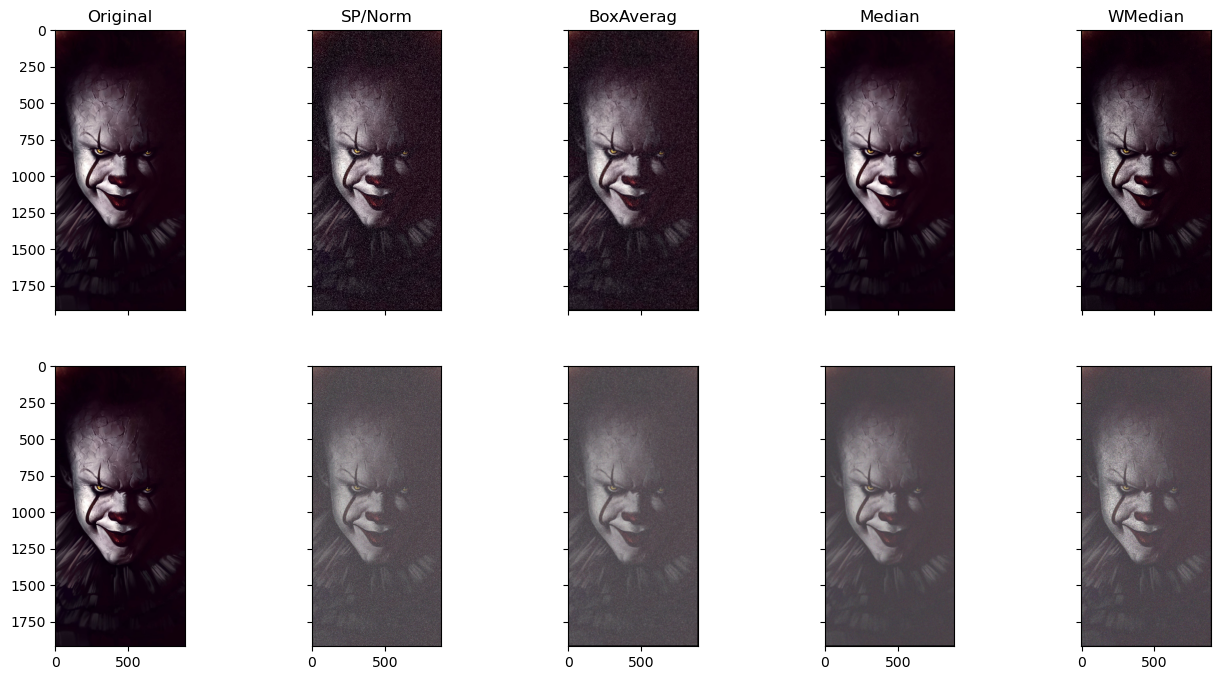

In [7]:
try:
    os.listdir('photos\\')
    if not os.path.exists('results\\'):
        os.mkdir('results\\')
except FileNotFoundError:
    os.mkdir('photos\\')
    if not os.path.exists('results\\'):
        os.mkdir('results\\')

with ProgressBar(total=17*len(os.listdir('photos\\'))) as progress:
    for item in os.listdir('photos\\'):
        img = Image.open('photos\\'+item)
        image = np.array(img)#, 0)
        # print(image.shape)
        if len(image.shape) >= 3:
            # sp noise
            sp_noise_img = sp_noise_color(image,0.07)
            progress.update(1)
            # norm noise
            norm_noise_img = norm_noise_color(image, mean=0, var=10, a=0.1)
            progress.update(1)
            # box for sp
            sp_noise_img_box = box_average_color(sp_noise_img, filter_size=(6, 6))
            progress.update(1)
            # med for sp
            sp_noise_img_med = median_color(sp_noise_img, filter_size=(6, 6))
            progress.update(1)
            # wmed for sp
            sp_noise_img_wmed = weight_median_color(sp_noise_img)
            progress.update(1)
            # box for norm
            norm_noise_img_box = box_average_color(norm_noise_img, filter_size=(6, 6))
            progress.update(1)
            # med for norm
            norm_noise_img_med = median_color(norm_noise_img, filter_size=(6, 6))
            progress.update(1)
            # wmed for norm
            norm_noise_img_wmed = weight_median_color(norm_noise_img)
            progress.update(1)
        else:
            # sp noise
            sp_noise_img = sp_noise_gray(image,0.07)
            progress.update(1)
            # norm noise
            norm_noise_img = norm_noise_gray(image, mean=0, var=10, a=0.1)
            progress.update(1)
            # box for sp
            sp_noise_img_box = box_average_gray(sp_noise_img, filter_size=(9, 9))
            progress.update(1)
            # med for sp
            sp_noise_img_med = median_gray(sp_noise_img, filter_size=(9, 9))
            progress.update(1)
            # wmed for sp
            sp_noise_img_wmed = weight_median_gray(sp_noise_img)
            progress.update(1)
            # box for norm
            norm_noise_img_box = box_average_gray(norm_noise_img, filter_size=(9, 9))
            progress.update(1)
            # med for norm
            norm_noise_img_med = median_gray(norm_noise_img, filter_size=(9, 9))
            progress.update(1)
            # wmed for norm
            norm_noise_img_wmed = weight_median_gray(norm_noise_img)
            progress.update(1)
        
        # print((sp_noise_img_box == sp_noise_img_med).all())
        
        # print([sp_noise_img_box == sp_img])
        
        sp_img = Image.fromarray(sp_noise_img)#.astype(np.uint8))
        progress.update(1)
        norm_img = Image.fromarray(norm_noise_img.astype(np.uint8))#.astype(np.uint8))
        progress.update(1)
        sp_noise_img_box = Image.fromarray(sp_noise_img_box.astype(np.uint8))
        progress.update(1)
        sp_noise_img_med = Image.fromarray(sp_noise_img_med.astype(np.uint8))
        progress.update(1)
        sp_noise_img_wmed = Image.fromarray(sp_noise_img_wmed.astype(np.uint8))
        progress.update(1)
        norm_noise_img_box = Image.fromarray(norm_noise_img_box.astype(np.uint8))
        progress.update(1)
        norm_noise_img_med = Image.fromarray(norm_noise_img_med.astype(np.uint8))
        progress.update(1)
        norm_noise_img_wmed = Image.fromarray(norm_noise_img_wmed.astype(np.uint8))
        progress.update(1)
        # sp_img.show()
        # norm_img.show()
        f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(16, 8))
        ax1.imshow(img)
        ax2.imshow(sp_img)
        ax3.imshow(sp_noise_img_box)#cv2.blur(sp_noise_img, (10, 10)))
        ax4.imshow(sp_noise_img_med)
        ax5.imshow(sp_noise_img_wmed)

        ax6.imshow(img)
        ax7.imshow(norm_img)
        ax8.imshow(norm_noise_img_box)
        ax9.imshow(norm_noise_img_med)
        ax10.imshow(norm_noise_img_wmed)

        ax1.set_title("Original")
        ax2.set_title("SP/Norm")
        ax3.set_title("BoxAverag")
        ax4.set_title("Median")
        ax5.set_title("WMedian")
        
        
#         sp_img.save('results\\'+item+'_sp_'+item) #res_
#         norm_img.save('results\\'+item+'_norm_'+item) #res_
        
#         sp_noise_img_box.save('results\\'+item+'_res_sp_box_'+item)
#         sp_noise_img_med.save('results\\'+item+'_res_sp_med_'+item)
#         sp_noise_img_wmed.save('results\\'+item+'_res_sp_wmed_'+item)
        
#         norm_noise_img_box.save('results\\'+item+'_res_norm_box_'+item)
#         norm_noise_img_med.save('results\\'+item+'_res_norm_med_'+item)
#         norm_noise_img_wmed.save('results\\'+item+'_res_norm_wmed_'+item)
        
        progress.update(1)